In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.api import SimpleExpSmoothing, Holt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('../DB/5m/ARBUSDT_5m.csv', parse_dates=True) 

# df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
# # # Convert 'date' to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])  # Assuming the 'date' is in milliseconds

# # # Set 'date' as index
df.set_index('datetime', inplace=True)

# df.iloc[0]
# df.dtypes
# df.head()
df.drop(['volume', 'quote_volume'], axis=1, inplace=True)
btc_test = df[:].copy()
btc_test

,open,high,low,close
datetime,,,,
2023-03-23 13:30:00,1.5754,1.6289,1.5282,1.5335
2023-03-23 13:35:00,1.5335,1.5766,1.4934,1.4934
2023-03-23 13:40:00,1.4934,1.4934,1.2500,1.2525
2023-03-23 13:45:00,1.2525,1.2670,1.1083,1.1849
2023-03-23 13:50:00,1.1849,1.3416,1.1555,1.1712
...,...,...,...,...
2024-12-28 18:05:00,0.7728,0.7730,0.7705,0.7718
2024-12-28 18:10:00,0.7718,0.7720,0.7709,0.7712
2024-12-28 18:15:00,0.7712,0.7719,0.7704,0.7705


In [4]:
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame containing the data
# 'close' is the target feature, and other features are predictors
X = df.drop(columns='close')  # Features
y = df['close']  # Target (Close prices)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
from sklearn.ensemble import GradientBoostingRegressor

# Use the best parameters from previous grid search
best_params = {'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1, 'n_estimators': 100}

# Initialize the model with the best parameters
model = GradientBoostingRegressor(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    n_estimators=best_params['n_estimators']
)

# Train the model
model.fit(X_train, y_train)


GradientBoostingRegressor(max_depth=15, min_samples_split=5)

In [6]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


Mean Squared Error: 5.104598621941622e-06
R^2 Score: 0.9999703471648059


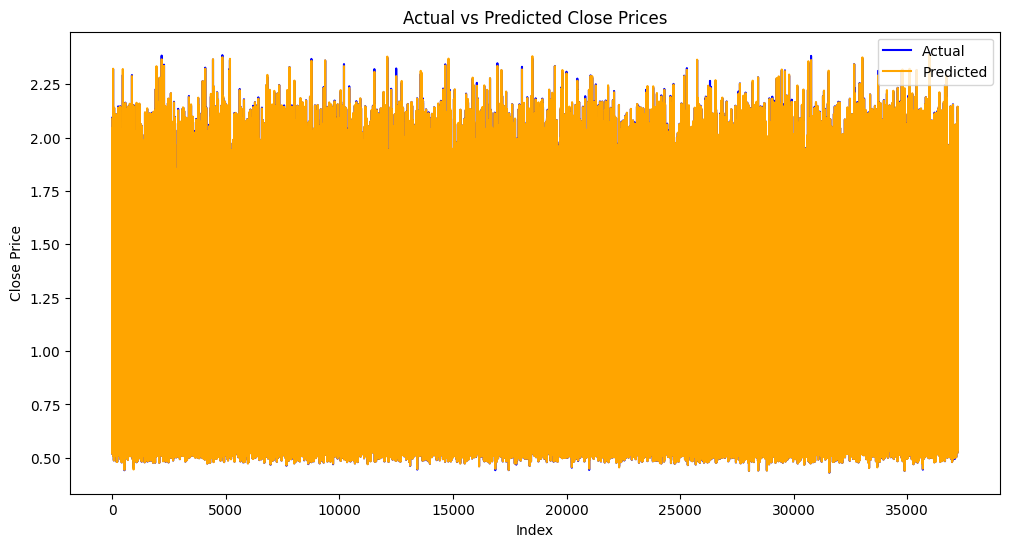

In [7]:
import matplotlib.pyplot as plt

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.reset_index(drop=True), label='Actual', color='blue')
plt.plot(pd.Series(y_pred).reset_index(drop=True), label='Predicted', color='orange')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()


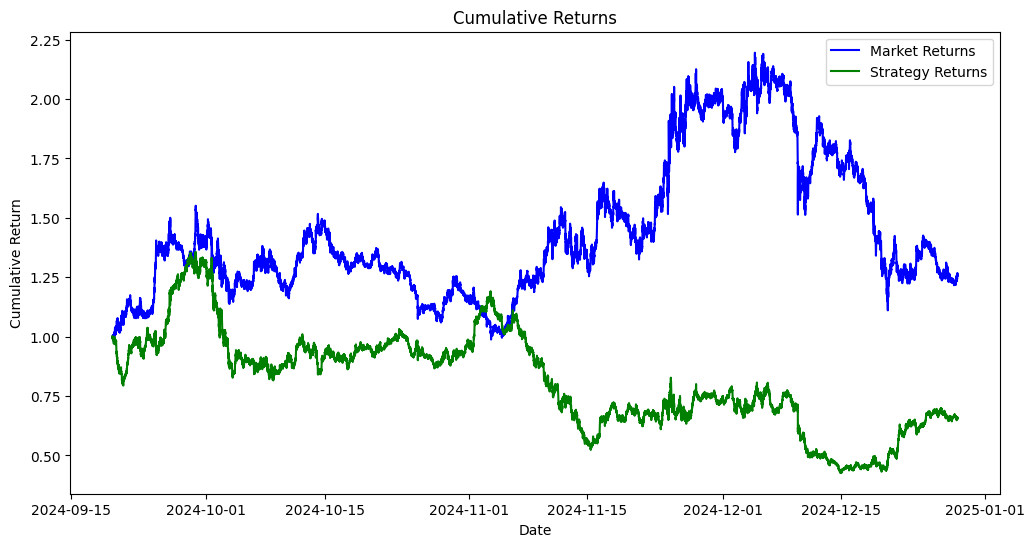

Mean Squared Error (MSE): 1.1556456674631065e-06
R² Score: 0.9998779392984669
Win Rate: 49.75%
Sharpe Ratio: -0.01


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('../DB/5m/SEIUSDT_5m.csv')

# Convert 'datetime' to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# Drop unnecessary columns
df.drop(['volume', 'quote_volume'], axis=1, inplace=True)

# Prepare features and target
close_prices = df['close']
features = df.drop(columns=['close'])

# Split the data into training and test sets
train_size = int(len(features) * 0.8)
train_features, test_features = features[:train_size], features[train_size:]
train_targets, test_targets = close_prices[:train_size], close_prices[train_size:]

# Train the model
model = RandomForestRegressor(max_depth=15, min_samples_leaf=1, min_samples_split=5, n_estimators=100, random_state=42)
model.fit(train_features, train_targets)

# Predict close prices
predicted_close = model.predict(test_features)

# Create a new DataFrame for test results
test_results = test_features.copy()
test_results['actual_close'] = test_targets.values
test_results['predicted_close'] = predicted_close

# Generate buy/sell signals
test_results['buy_signal'] = test_results['predicted_close'] > test_results['actual_close']
test_results['sell_signal'] = test_results['predicted_close'] < test_results['actual_close']

# Calculate trading returns
test_results['returns'] = test_results['actual_close'].pct_change()
test_results['strategy_returns'] = test_results['returns'] * (
    test_results['buy_signal'].shift(1).fillna(0) - test_results['sell_signal'].shift(1).fillna(0)
)

# Cumulative returns
test_results['cumulative_returns'] = (1 + test_results['returns']).cumprod()
test_results['cumulative_strategy_returns'] = (1 + test_results['strategy_returns']).cumprod()

# Evaluate model performance
mse = np.mean((test_results['predicted_close'] - test_results['actual_close']) ** 2)
r2 = model.score(test_features, test_targets)

# Calculate win rate
test_results['profitable_trades'] = test_results['strategy_returns'] > 0
win_rate = test_results['profitable_trades'].mean()

# Sharpe ratio
risk_free_rate = 0.01 / 365  # Daily risk-free rate (example: 1% annualized)
sharpe_ratio = (test_results['strategy_returns'].mean() - risk_free_rate) / test_results['strategy_returns'].std()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(test_results.index, test_results['cumulative_returns'], label='Market Returns', color='blue')
plt.plot(test_results.index, test_results['cumulative_strategy_returns'], label='Strategy Returns', color='green')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

# Print metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'R² Score: {r2}')
print(f'Win Rate: {win_rate * 100:.2f}%')
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
